# Image Matching and Homography Estimation with OpenCV and LightGlue

In [1]:
import os
import cv2 
import time
import json
import math
import torch
import numpy as np
from vidstab import VidStab
import matplotlib.pyplot as plt

from lightglue import viz2d
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd, load_image_from_path
import CSRansac

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
#matcher = LightGlue(features='superpoint', depth_confidence=0.9, width_confidence=0.95).eval().to(device)
matcher = LightGlue(features='superpoint', depth_confidence=-1, width_confidence=-1).eval().to(device)
#matcher.compile(mode='reduce-overhead')

In [4]:
print(torch.__version__)
print(device)

2.1.2
cuda


In [5]:
def match_lightglue(img0, img1):
    img0 = load_image(img0)
    img1 = load_image(img1)

    # extract local features
    feats0 = extractor.extract(img0.to(device))  # auto-resize the image, disable with resize=None
    feats1 = extractor.extract(img1.to(device))
    
    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
    
    # get results
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = kpts0[matches[..., 0]]  # coordinates in img0, shape (K,2)
    points1 = kpts1[matches[..., 1]]  # coordinates in img1, shape (K,2)
        
    return {
        "points0": points0,
        "points1": points1,
    }

In [6]:
stabilizer = VidStab()

def matching_keypoints(target_img, video_img, stabilizing=False):
    # 이미지를 불러옴
    img0 = load_image(target_img, grayscale=True)
    if stabilizing == True:
        img1 = cv2.imread(video_img)
        img1 = stabilizer.stabilize_frame(img1)
        img1 = load_image(img1, grayscale=True)
    else:
        img1 = load_image(video_img , grayscale=True)

    # extract local features
    feats0 = extractor.extract(img0.to(device))  # auto-resize the image, disable with resize=None
    feats1 = extractor.extract(img1.to(device))

    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

    # get results
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = kpts0[matches[..., 0]]  # coordinates in img0, shape (K,2)
    points1 = kpts1[matches[..., 1]]  # coordinates in img1, shape (K,2)

    return {
        "points0": points0,
        "points1": points1,
    }

In [7]:
def get_errors(coord_list, float_origin_coordinate, len_coord):
    misannotate_error = 0
    pixel_error = 0
    
    for i in range(len_coord):
        origin_x = float_origin_coordinate[i][0]
        origin_y = float_origin_coordinate[i][1]
        
        for j in range(len(coord_list[i])-1):
            _coord = coord_list[i][j]
            
            x = _coord[0][0]
            y = _coord[0][1]
            
            x = x / 640
            y = y / 480
            
            x = round(x, 4)
            y = round(y, 4)
            
            # disappear_error
            # if x < 0 or x > 1 or y < 0 or y > 1:
            #     disappear_error += 1
            
            distance = math.sqrt((origin_x - x)**2 + (origin_y - y)**2)
            
            # num_error
            if distance > 0.1:
                misannotate_error += 1
            
            # pixel_error
            if distance > pixel_error:
                pixel_error = distance
                
    return misannotate_error, pixel_error

## Dataset 전처리

In [8]:
aircraft_datasets = "D:/aircraft_datasets/"

lables = os.path.join(aircraft_datasets + "label")
video_dir = os.path.join(aircraft_datasets, "video")
stabilized_video_dir = os.path.join(aircraft_datasets, "stabilized_video")
stabilized_frame_dir = os.path.join(aircraft_datasets, "stabilized_frame")
target_image_dir = os.path.join(aircraft_datasets, "target_image")
# 비디오 안정화 객체 생성
stabilizer = VidStab()

In [9]:
origin_coordinate = []

# 원점 좌표값 불러오기
for label_file in os.listdir(lables):
    label_path = os.path.join(lables, label_file)
    with open(label_path, "r") as f:
        json_file = json.load(f)
        coord = json_file["targetAnnotation"]
        coord[0] = coord[0] * 640
        coord[1] = coord[1] * 480
        origin_coordinate.append(coord)

print(origin_coordinate)
print(len(origin_coordinate))


[[319.171968, 270.55248], [320.0, 265.24536], [344.464896, 256.02912], [313.576128, 257.29579199999995], [325.48172800000003, 168.083808], [315.939648, 202.48910399999997], [325.479232, 168.080352], [312.391232, 306.426768], [320.0, 265.23864], [331.487168, 26.902847999999988], [316.5232, 203.087808], [329.47750399999995, 59.02296000000001], [320.0, 337.57583999999997], [324.136448, 161.35992000000002], [309.34656, 253.744368], [321.263104, 248.872656], [332.852352, 236.02262399999998], [326.04812799999996, 203.801712], [318.48947200000003, 251.060496], [320.964672, 255.825552], [321.25523200000003, 215.70609599999997], [319.453312, 225.751632], [319.45344, 180.868992], [321.200512, 215.63779200000002], [321.227712, 215.671728], [316.37516800000003, 230.084016], [316.20556799999997, 231.432768], [320.89824, 312.286224], [320.950912, 198.62135999999998], [315.928128, 231.49977600000003], [320.895168, 257.614128], [320.82163199999997, 257.47713600000003], [320.820608, 257.477952], [320.6

In [10]:
float_origin_coordinate = []
lables = os.path.join(aircraft_datasets + "/label")
# 원점 좌표값 불러오기
for label in os.listdir(lables):
    label_path = os.path.join(lables, label)
    with open(label_path, "r") as f:
        json_file = json.load(f)
        coord = json_file["targetAnnotation"]
        float_origin_coordinate.append(coord)
    
        
print(float_origin_coordinate)
print(len(float_origin_coordinate))
print(type(float_origin_coordinate[0][0]))

[[0.4987062, 0.563651], [0.5, 0.5525945], [0.5382264, 0.5333939999999999], [0.4899627, 0.5360328999999999], [0.5085652, 0.3501746], [0.4936557, 0.42185229999999996], [0.5085613, 0.3501674], [0.4881113, 0.6383890999999999], [0.5, 0.5525804999999999], [0.5179487, 0.056047599999999975], [0.4945675, 0.4230996], [0.5148086, 0.12296450000000003], [0.5, 0.703283], [0.5064632, 0.33616650000000003], [0.483354, 0.5286341], [0.5019736, 0.5184847], [0.5200818, 0.4917138], [0.5094502, 0.4245869], [0.4976398, 0.5230427], [0.5015073, 0.5329699], [0.5019613, 0.44938769999999995], [0.4991458, 0.4703159], [0.499146, 0.3768104], [0.5018758, 0.4492454], [0.5019183, 0.4493161], [0.4943362, 0.4793417], [0.4940712, 0.4821516], [0.5014035, 0.6505963], [0.5014858, 0.41379449999999995], [0.4936377, 0.48229120000000003], [0.5013987, 0.5366961], [0.5012838, 0.5364107], [0.5012822, 0.5364124], [0.5010208, 0.6041888], [0.5011398, 0.5360265], [0.5, 0.6081664], [0.5, 0.53695], [0.5, 1.01116514], [0.4968961, 0.5822069

In [11]:
video_dir = os.path.join(aircraft_datasets, "video")
output_dir = os.path.join(aircraft_datasets, "frames_from_video")
stabilized_frame_path = os.path.join(aircraft_datasets, "stabilized_frame")

In [12]:
# 원본 이미지 경로를 저장할 리스트
images = [[] for i in range(len(origin_coordinate))]
i = 0

# output_dir 내의 모든 폴더에 대한 반복
for folder_name in os.listdir(output_dir):
    folder_path = os.path.join(output_dir, folder_name)
    
    for name in os.listdir(folder_path):
        filename = os.path.join(folder_path, name)
        images[i].append(filename)
    
    i = i + 1

# images 리스트의 길이 반환
# num_images = len(images)
# print(f"총 이미지 수: {num_images}")

print(len(images[0]))

368


In [13]:
stabilized_images = [[] for i in range(len(origin_coordinate))]
i = 0

# output_dir 내의 모든 폴더에 대한 반복
for folder_name in os.listdir(stabilized_frame_path):
    folder_path = os.path.join(stabilized_frame_path, folder_name)
    
    for name in os.listdir(folder_path):
        filename = os.path.join(folder_path, name)
        stabilized_images[i].append(filename)
        
    i = i + 1
    
# images 리스트의 길이 반환
print(len(stabilized_images[0]))

368


## Error Estimate

## 기존 에러 평가 코드(타깃 이미지)

In [25]:
#원본 이미지를 기준으로 호모그래피 행렬을 구하고, 호모그래피 행렬을 이용하여 특징점의 좌표를 변환하는 코드
len_coord = len(origin_coordinate)

coord_list = [[] for _i in range(len(origin_coordinate))]

disappear_errors = []
misannotate_errors = []
pixel_errors = []

missing_inlier = 0
failed_inliers = 0

# 10번 반복하여 측정한 에러를 구함
for k in range(10):
    # 좌표의 개수(동영상의 개수)만큼 반복
    for i in range(len_coord):
        _images = images[i]
        _len_images = len(_images)
        x = origin_coordinate[i][0]
        y = origin_coordinate[i][1]
        
        # 두 번째 차원의 리스트 초기화
        coord_list[i] = [[] for _ in range(_len_images)]

        img0 = _images[0] # 첫 번째 이미지를 target 이미지로 설정
        for j in range(_len_images):
            if j != _len_images - 1:
                img1 = _images[j+1]

                # LightGlue
                results_lightglue = match_lightglue(img0, img1)
                target_keypoint = results_lightglue["points0"].cpu().numpy()
                frame_keypoint = results_lightglue["points1"].cpu().numpy()
                if len(target_keypoint) < 6:
                    missing_inlier += 1

                homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
                if mask == 0.3:
                    failed_inliers += 1
                projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)

                coord_list[i][j].append(projected_pts)
                
    #에러 측정            
    disappear_error = 0
    misannotate_error = 0
    pixel_error = 0

    for i in range(len_coord):
        float_origin_x = float_origin_coordinate[i][0]
        float_origin_y = float_origin_coordinate[i][1]
        
        origin_x = origin_coordinate[i][0]
        origin_y = origin_coordinate[i][1]
        
        for j in range(len(coord_list[i])-1):
            _coord = coord_list[i][j]
            
            x = _coord[0][0]
            y = _coord[0][1]
            
            x = x / 640
            y = y / 480
            
            x = round(x, 4)
            y = round(y, 4)
            
            # disappear_error
            if x < 0 or x > 1 or y < 0 or y > 1:
                disappear_error += 1
            
            distance = math.sqrt((float_origin_x - x)**2 + (float_origin_y - y)**2)
            
            # num_error
            if distance > 0.1:
                misannotate_error += 1
                
            # pixel_error
            if distance > pixel_error:
                pixel_error = distance
               
    print("disappear_error:", disappear_error)
    print("misannotate_error:", misannotate_error)
    print("pixel_error:", pixel_error)

    disappear_errors.append(disappear_error)
    misannotate_errors.append(misannotate_error)
    pixel_errors.append(pixel_error)
    

print("missing_inlier:", missing_inlier)
print("failed_inliers:", failed_inliers)

NameError: name 'images' is not defined

In [ ]:
error1 = sum(disappear_errors) / len(disappear_errors)
error2 = sum(misannotate_errors) / len(misannotate_errors)
error3 = sum(pixel_errors) / len(pixel_errors)

print("disappear_error:", error1)
print("num_error:", error2)
print("pixel_error:", error3)

disappear_error: 267.4
num_error: 855.6
pixel_error: 6.883285535124935


## 에러 평가 코드(인접 프레임)

In [17]:
#원본 이미지를 기준으로 호모그래피 행렬을 구하고, 호모그래피 행렬을 이용하여 특징점의 좌표를 변환하는 코드
len_coord = len(origin_coordinate)

coord_list = [[] for _i in range(len(origin_coordinate))]

# disappear_errors = []
misannotate_errors = []
pixel_errors = []

failed_inliers = 0
zero_inliers = 0

inliers = 0

# 10번 반복하여 측정한 에러를 구함
for k in range(1):
    # 좌표의 개수(동영상의 개수)만큼 반복
    for i in range(len_coord):
        _images = images[i]
        _len_images = len(_images)
        x = origin_coordinate[i][0]
        y = origin_coordinate[i][1]
        
        # 두 번째 차원의 리스트 초기화
        coord_list[i] = [[] for _ in range(_len_images)]

        img0 = _images[0] # 첫 번째 이미지를 target 이미지로 설정
        for j in range(_len_images):
            if j != _len_images - 1:
                img1 = _images[j+1]

                # LightGlue
                results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
                target_keypoint = results_lightglue["points0"].cpu().numpy()
                frame_keypoint = results_lightglue["points1"].cpu().numpy()
                if len(target_keypoint) < 6:
                    failed_inliers += 1
                    continue

                homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
                if mask <= 0.3:
                    if mask == 0:
                        zero_inliers += 1
                    failed_inliers += 1
                
                inliers += mask
                projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)

                coord_list[i][j].append(projected_pts)
                
                img0 = img1
                
    #에러 측정            
    # disappear_error = 0
    misannotate_error, pixel_error = get_errors(coord_list, float_origin_coordinate)
               
    #print("disappear_error:", disappear_error)
    print("misannotate_error:", misannotate_error)
    print("pixel_error:", pixel_error)

    #disappear_errors.append(disappear_error)
    misannotate_errors.append(misannotate_error)
    pixel_errors.append(pixel_error)
    
print("inliers:", inliers / len(images))
print("failed_inliers:", failed_inliers)
print("zero_inliers:", zero_inliers)

misannotate_error: 0
pixel_error: 0.058761471724418084
inliers: 305.45385315329554
failed_inliers: 955
zero_inliers: 0


## 에러 평가 코드(이미지 안정화)

In [28]:
#원본 이미지를 기준으로 호모그래피 행렬을 구하고, 호모그래피 행렬을 이용하여 특징점의 좌표를 변환하는 코드
len_coord = len(origin_coordinate)

coord_list = [[] for _i in range(len(origin_coordinate))]

# disappear_errors = []
misannotate_errors = []
pixel_errors = []

failed_inliers = 0
zero_inliers = 0

inliers = 0

epochs = 10

# 10번 반복하여 측정한 에러를 구함
for k in range(epochs):
    # 좌표의 개수(동영상의 개수)만큼 반복
    for i in range(len_coord):
        _images = stabilized_images[i]
        _len_images = len(_images)
        x = origin_coordinate[i][0]
        y = origin_coordinate[i][1]
        
        # 두 번째 차원의 리스트 초기화
        coord_list[i] = [[] for _ in range(_len_images)]

        img0 = _images[0] # 첫 번째 이미지를 target 이미지로 설정
        for j in range(_len_images):
            if j != _len_images - 1:
                img1 = _images[j+1]

                # LightGlue
                results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
                target_keypoint = results_lightglue["points0"].cpu().numpy()
                frame_keypoint = results_lightglue["points1"].cpu().numpy()
                if len(target_keypoint) < 6:
                    failed_inliers += 1
                    continue

                homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
                if mask <= 0.3:
                    if mask == 0:
                        zero_inliers += 1
                    failed_inliers += 1
                
                inliers += mask
                projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)

                coord_list[i][j].append(projected_pts)
                
                img0 = img1
                
    #에러 측정            
    # disappear_error = 0
    misannotate_error, pixel_error = get_errors(coord_list, float_origin_coordinate)
               
    #print("disappear_error:", disappear_error)
    print("misannotate_error:", misannotate_error)
    print("pixel_error:", pixel_error)

    #disappear_errors.append(disappear_error)
    misannotate_errors.append(misannotate_error)
    pixel_errors.append(pixel_error)
    
print("inliers:", inliers / len(images))
print("failed_inliers:", failed_inliers)
print("zero_inliers:", zero_inliers)

misannotate_error: 0
pixel_error: 0.050013717660357865
misannotate_error: 1
pixel_error: 0.11768057115437372
misannotate_error: 0
pixel_error: 0.06512283939770747
misannotate_error: 0
pixel_error: 0.0671514593081909
misannotate_error: 0
pixel_error: 0.05411184712444778
misannotate_error: 0
pixel_error: 0.07403364800852379
misannotate_error: 0
pixel_error: 0.0734346283657758
misannotate_error: 0
pixel_error: 0.07215342899141808
misannotate_error: 0
pixel_error: 0.058189350256035645
misannotate_error: 0
pixel_error: 0.062043674997694934
inliers: 127355.83463355788
failed_inliers: 6783
zero_inliers: 0


In [29]:
error1 = sum(misannotate_errors) / len(misannotate_errors)
error2 = sum(pixel_errors) / len(pixel_errors)
error3 = inliers / 14720 * epochs


print("num_error:", error1)
print("pixel_error:", error2)
print("inliers:", error3)

num_error: 0.1
pixel_error: 0.06939351652645259
inliers: 8.651890939779747


## 에러 평가 코드(optical flow)

In [23]:
# 칼만 필터 초기화
kalman = cv2.KalmanFilter(8, 4)
kalman.measurementMatrix = np.eye(4, 8, dtype=np.float32)
kalman.transitionMatrix = np.eye(8, dtype=np.float32)
kalman.processNoiseCov = np.eye(8, dtype=np.float32) * 0.01
kalman.measurementNoiseCov = np.eye(4, dtype=np.float32) * 0.1
kalman.errorCovPost = np.eye(8, dtype=np.float32)

#원본 이미지를 기준으로 호모그래피 행렬을 구하고, 호모그래피 행렬을 이용하여 특징점의 좌표를 변환하는 코드
len_coord = len(origin_coordinate)

coord_list = [[] for _i in range(len(origin_coordinate))]

# disappear_errors = []
misannotate_errors = []
pixel_errors = []

failed_inliers = 0
zero_inliers = 0

inlier_rates = 0

# Lucas-Kanade optical flow 파라미터
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# 좋은 특징점 찾기 파라미터
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

epochs = 10

count = 0

# 10번 반복하여 측정한 에러를 구함
for k in range(epochs):
    # 좌표의 개수(동영상의 개수)만큼 반복
    for i in range(len_coord):
        _images = images[i]
        _len_images = len(_images)
        x = origin_coordinate[i][0]
        y = origin_coordinate[i][1]
        
        # 두 번째 차원의 리스트 초기화
        coord_list[i] = [[] for _ in range(_len_images)]

        img0 = _images[0] # 첫 번째 이미지를 target 이미지로 설정
        prev_gray = cv2.imread(img0, cv2.IMREAD_GRAYSCALE)
        prev_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
        
        for j in range(_len_images):
            if j != _len_images - 1:
                img1 = _images[j+1]
                
                # 첫 프레임에서 특징점 찾기
                gray = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
                next_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None, **lk_params)
                good_old = prev_points[status == 1]
                good_new = next_points[status == 1]

                if len(good_new) >= 4:
                    H, mask = cv2.findHomography(good_old, good_new, cv2.RANSAC, 5.0)
                        
                    if H is not None:
                        inliers = CSRansac.calculate_inliers(H, good_old, good_new, 5)
                        inlier_rate = inliers / len(good_old)
                        if inlier_rate <= 0.3:
                            failed_inliers += 1
                        inlier_rates += inlier_rate
                            
                        # 원본 이미지의 좌표를 변환
                        points = np.array([[x, y]], dtype='float32')
                        projected_points = cv2.perspectiveTransform(np.array([points]), H)
                        # 칼만 필터 업데이트
                        measured = np.array([[projected_points[0][0][0], projected_points[0][0][1], 0, 0]], dtype=np.float32).T
                        kalman.correct(measured)
                        prediction = kalman.predict()
                        predicted_points = (prediction[0][0], prediction[1][0])
                else:
                    failed_inliers += 1       
                

                projected_pts = tuple(projected_points[0][0])
                coord_list[i][j].append(projected_pts)
                
                prev_gray = gray
                prev_points = good_new.reshape(-1, 1, 2)
                
                count += 1
                
                
    #에러 측정            
    # disappear_error = 0
    misannotate_error, pixel_error = get_errors(coord_list, float_origin_coordinate, len_coord)
               
    #print("disappear_error:", disappear_error)
    print("misannotate_error:", misannotate_error)
    print("pixel_error:", pixel_error)

    #disappear_errors.append(disappear_error)
    misannotate_errors.append(misannotate_error)
    pixel_errors.append(pixel_error)
    
print("failed_inliers:", failed_inliers)
print("zero_inliers:", zero_inliers)
print(count)

misannotate_error: 0
pixel_error: 0.06245877990587073
misannotate_error: 0
pixel_error: 0.06245877990587073
misannotate_error: 0
pixel_error: 0.06245877990587073
misannotate_error: 0
pixel_error: 0.06245877990587073
misannotate_error: 0
pixel_error: 0.06245877990587073
misannotate_error: 0
pixel_error: 0.06245877990587073
misannotate_error: 0
pixel_error: 0.06245877990587073
misannotate_error: 0
pixel_error: 0.06245877990587073
misannotate_error: 0
pixel_error: 0.06245877990587073
misannotate_error: 0
pixel_error: 0.06245877990587073
failed_inliers: 730
zero_inliers: 0
146810


In [24]:
error1 = sum(misannotate_errors) / len(misannotate_errors)
error2 = sum(pixel_errors) / len(pixel_errors)
error3 = inlier_rates / 14720 * epochs


print("num_error:", error1)
print("pixel_error:", error2)
print("inliers:", error3)
print("failed_inliers:", failed_inliers)

num_error: 0.0
pixel_error: 0.06245877990587072
inliers: 98.73362610546474
failed_inliers: 730


## 에러 평가 코드 (lightglue + 칼만 필터)

In [20]:
#원본 이미지를 기준으로 호모그래피 행렬을 구하고, 호모그래피 행렬을 이용하여 특징점의 좌표를 변환하는 코드
len_coord = len(origin_coordinate)

# 칼만 필터 초기화
kalman = cv2.KalmanFilter(8, 4)
kalman.measurementMatrix = np.eye(4, 8, dtype=np.float32)
kalman.transitionMatrix = np.eye(8, dtype=np.float32)
kalman.processNoiseCov = np.eye(8, dtype=np.float32) * 0.01
kalman.measurementNoiseCov = np.eye(4, dtype=np.float32) * 0.1
kalman.errorCovPost = np.eye(8, dtype=np.float32)

coord_list = [[] for _i in range(len(origin_coordinate))]

# disappear_errors = []
misannotate_errors = []
pixel_errors = []

failed_inliers = 0
zero_inliers = 0

inliers = 0

epochs = 10

count = 0

# 10번 반복하여 측정한 에러를 구함
for k in range(epochs):
    # 좌표의 개수(동영상의 개수)만큼 반복
    for i in range(len_coord):
        _images = images[i]
        _len_images = len(_images)
        x = origin_coordinate[i][0]
        y = origin_coordinate[i][1]
        
        # 두 번째 차원의 리스트 초기화
        coord_list[i] = [[] for _ in range(_len_images)]

        img0 = _images[0] # 첫 번째 이미지를 target 이미지로 설정
        for j in range(_len_images):
            if j != _len_images - 1:
                img1 = _images[j+1]

                # LightGlue
                results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
                target_keypoint = results_lightglue["points0"].cpu().numpy()
                frame_keypoint = results_lightglue["points1"].cpu().numpy()
                if len(target_keypoint) < 6:
                    failed_inliers += 1
                    continue

                homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
                if mask <= 0.3:
                    if mask == 0:
                        zero_inliers += 1
                    failed_inliers += 1
                
                inliers += mask
                projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)
                measured = np.array([[projected_pts[0], projected_pts[1], 0, 0]], dtype=np.float32).T
                kalman.correct(measured)
                prediction = kalman.predict()
                predicted_points = (prediction[0][0], prediction[1][0])
                
                coord_list[i][j].append(predicted_points)
                
                count += 1
                img0 = img1
                
    #에러 측정            
    # disappear_error = 0
    misannotate_error, pixel_error = get_errors(coord_list, float_origin_coordinate, len_coord)
               
    #print("disappear_error:", disappear_error)
    print("misannotate_error:", misannotate_error)
    print("pixel_error:", pixel_error)

    #disappear_errors.append(disappear_error)
    misannotate_errors.append(misannotate_error)
    pixel_errors.append(pixel_error)
    
print("inliers:", inliers / len(images))
print("failed_inliers:", failed_inliers)
print("zero_inliers:", zero_inliers)
print(count)

misannotate_error: 47
pixel_error: 0.7526023676015376
misannotate_error: 38
pixel_error: 0.424236197051831
misannotate_error: 38
pixel_error: 0.4246178367532386
misannotate_error: 39
pixel_error: 0.4245307653032934
misannotate_error: 38
pixel_error: 0.422831359396391
misannotate_error: 38
pixel_error: 0.42492540179306765
misannotate_error: 38
pixel_error: 0.423720660210238
misannotate_error: 38
pixel_error: 0.423936305462271
misannotate_error: 37
pixel_error: 0.42571250849487613
misannotate_error: 38
pixel_error: 0.4240335926421396
inliers: 3056.7770712552397
failed_inliers: 9482
zero_inliers: 0
146810


In [21]:
error1 = sum(misannotate_errors) / len(misannotate_errors)
error2 = sum(pixel_errors) / len(pixel_errors)
error3 = inliers / 14720 * epochs


print("num_error:", error1)
print("pixel_error:", error2)
print("inliers:", error3)

num_error: 38.9
pixel_error: 0.4571146994708884
inliers: 83.06459432758803


In [27]:
print(coord_list[0][0])

[array([319.17197, 270.5525 ], dtype=float32)]


In [ ]:
error1 = sum(misannotate_errors) / len(misannotate_errors)
error2 = sum(pixel_errors) / len(pixel_errors)
error3 = inliers / 14720 * 10


print("num_error:", error1)
print("pixel_error:", error2)
print("inliers:", error3)

## 비디오 inlier rate 출력

In [21]:
x = 637 / 2
y = 367 / 2

image0 = load_image_from_path("img0.png", grayscale=True)
cap = cv2.VideoCapture('demo_video_resized.mp4')

inlier_rates = []

# 각 프레임 처리
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    feats0 = extractor.extract(image0.to(device))
    image1 = load_image(frame, grayscale=True)
    feats1 = extractor.extract(image1.to(device))
    
    matches01 = matcher({"image0": feats0, "image1": feats1})
    
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension
    
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    
    homography, mask = CSRansac.csransac(m_kpts0.cpu().numpy(), m_kpts1.cpu().numpy())
    inlier_rates.append(mask)
    
    image0 = image1

In [24]:
# 배열 내에서 0.3 이하의 값이 몇 개인지 확인
count = 0
for i in inlier_rates:
    if i < 0.3:
        count += 1
        print(i)
        
print(count)

-1
-1
-1
-1
-1
-1
-1
-1
0.25680933852140075
0.09437751004016064
-1
-1
0.01342882721575649
-1
0.21180555555555555
-1
-1
-1
18


In [23]:
# inlier rate를 json 파일로 저장
with open("inlier_rate.json", "w") as f:
    json.dump(inlier_rates, f)
    



In [4]:
# inlier rate를 블러오기
with open("lightglue_inlier_rate.json", "r") as f:
    inlier_rates = json.load(f)

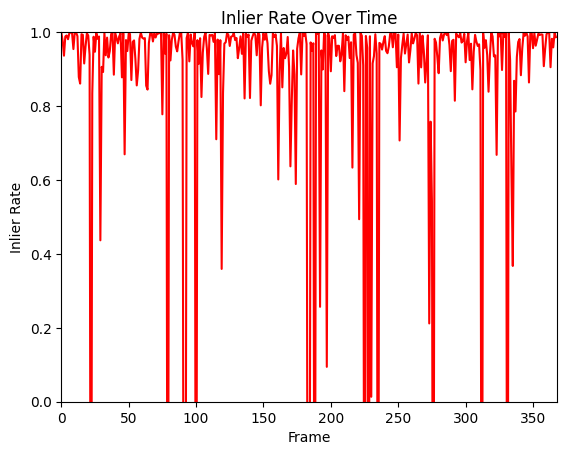

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# # inlier rates 예시 데이터
# inlier_rates = np.random.rand(368)  # 예시로 240개의 데이터를 랜덤으로 생성

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'r-', animated=True)

def init():
    ax.set_xlim(0, len(inlier_rates))  # 프레임 수에 따라 조절
    ax.set_ylim(0, 1)  # inlier rate의 최댓값에 따라 y축 범위 조절
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(inlier_rates[frame])
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(inlier_rates)),
                    init_func=init, blit=True, interval=(1000/30))

ani.save('inlier_rate_animation.gif', writer='pillow', fps=30)


plt.xlabel('Frame')
plt.ylabel('Inlier Rate')
plt.title('Inlier Rate Over Time')
plt.show()


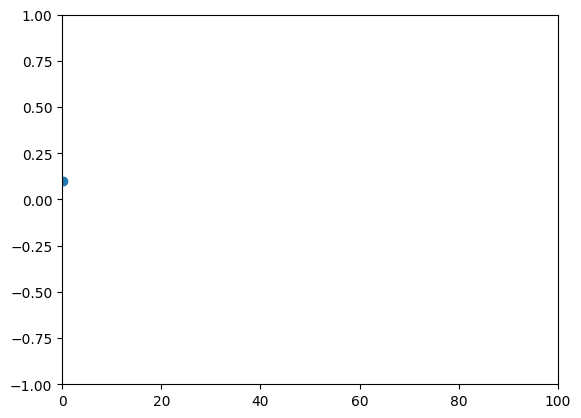

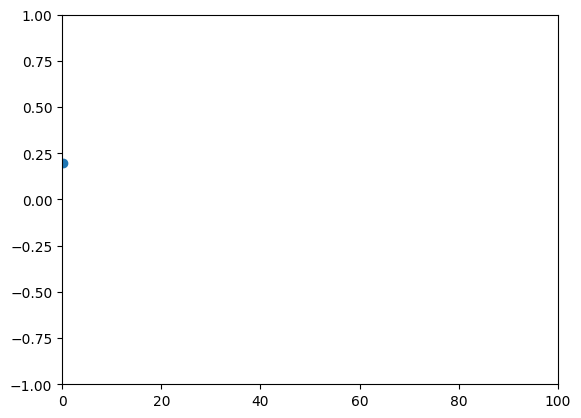

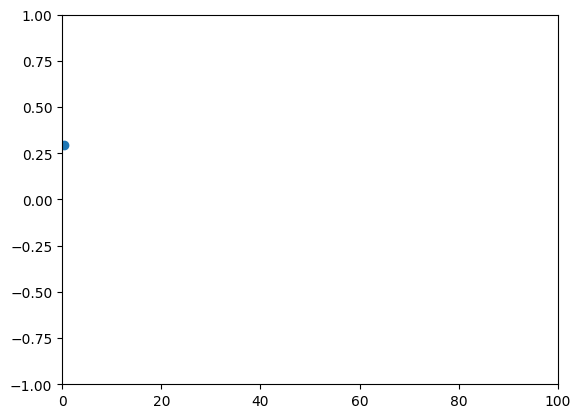

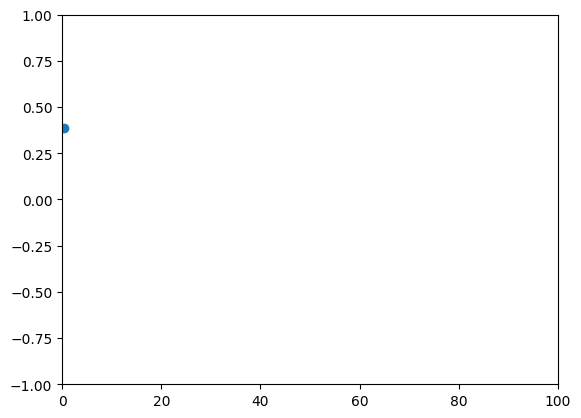

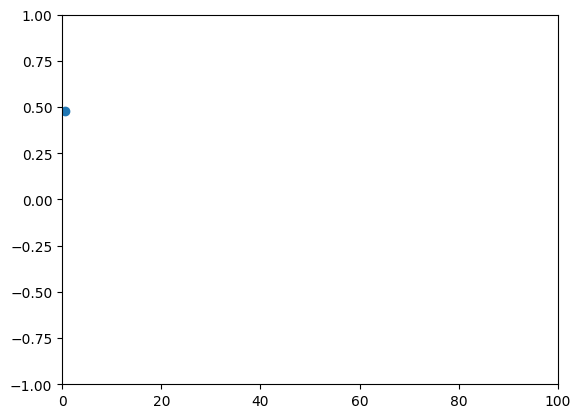

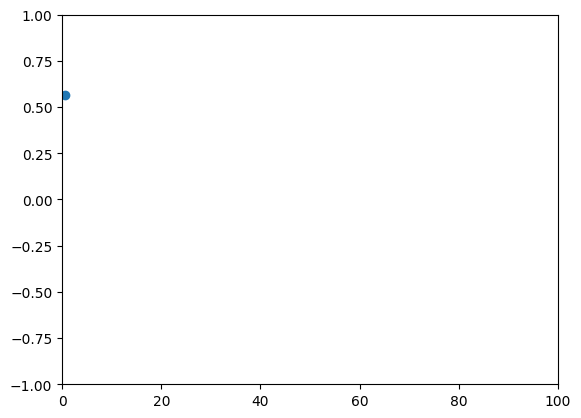

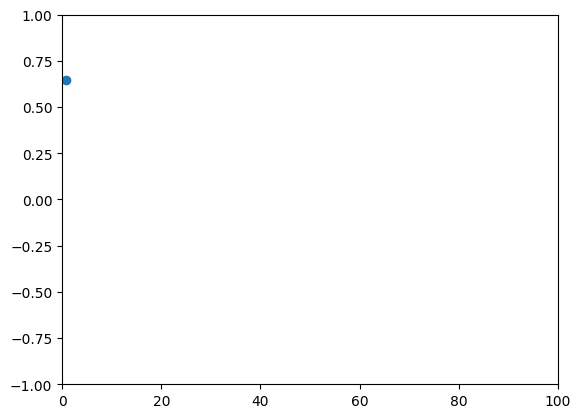

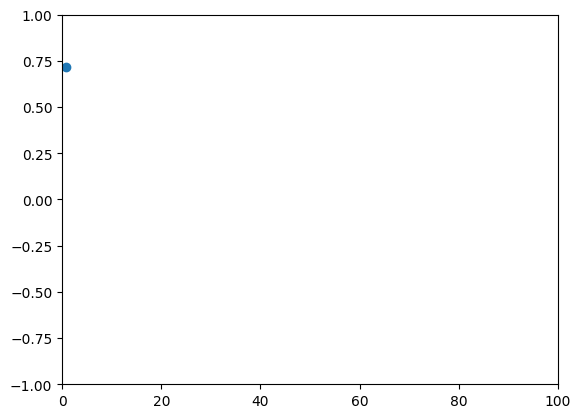

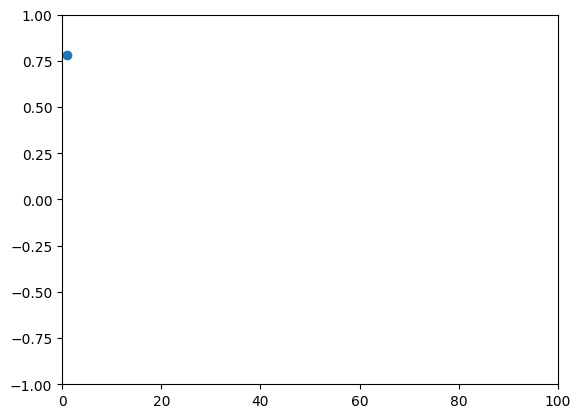

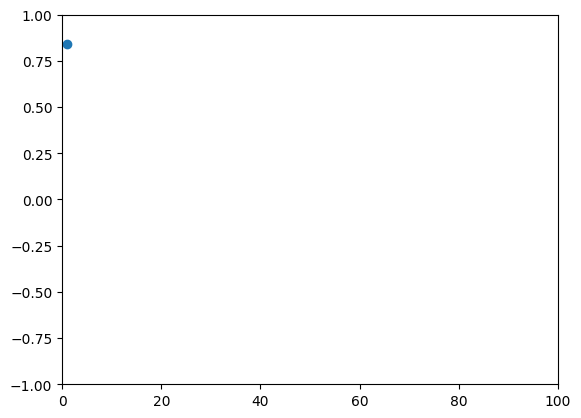

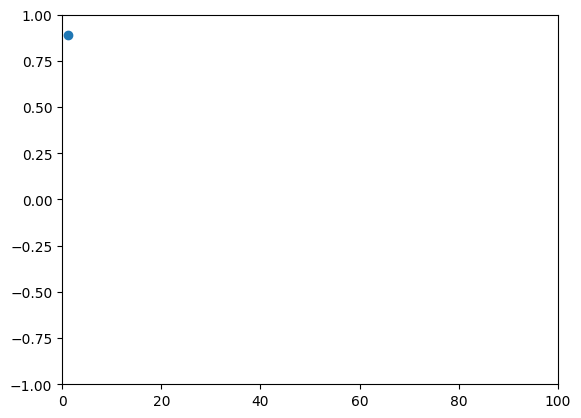

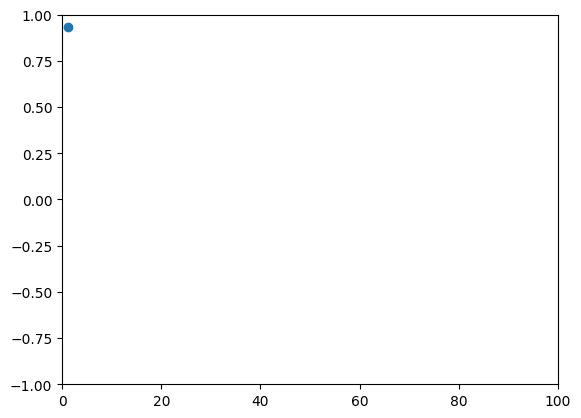

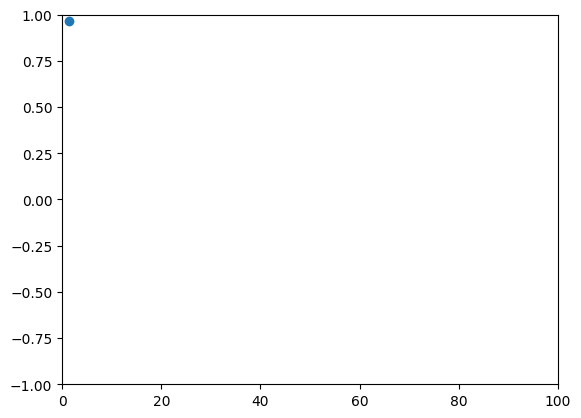

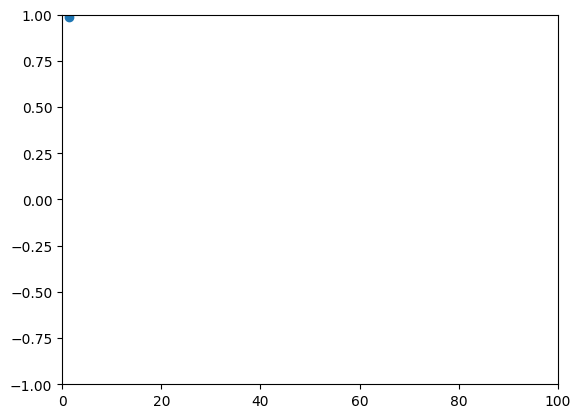

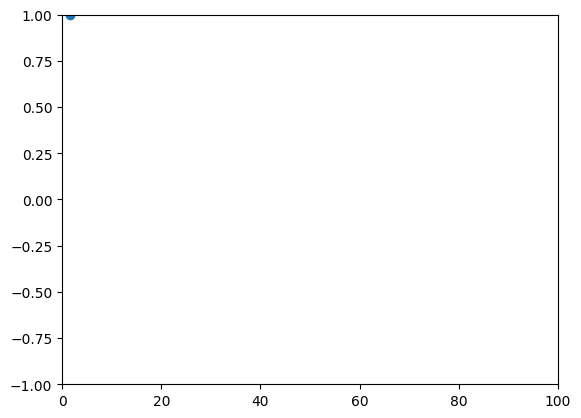

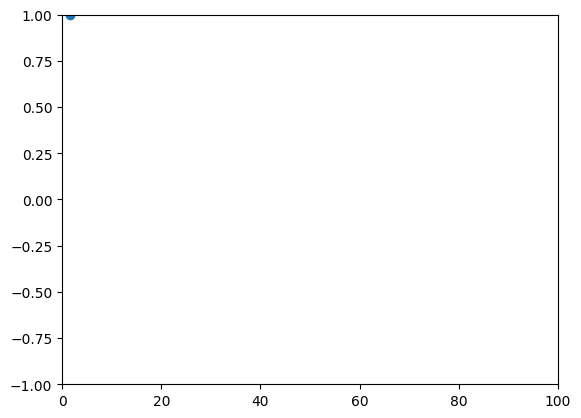

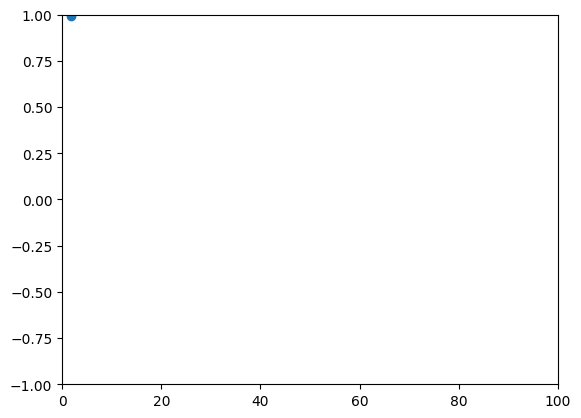

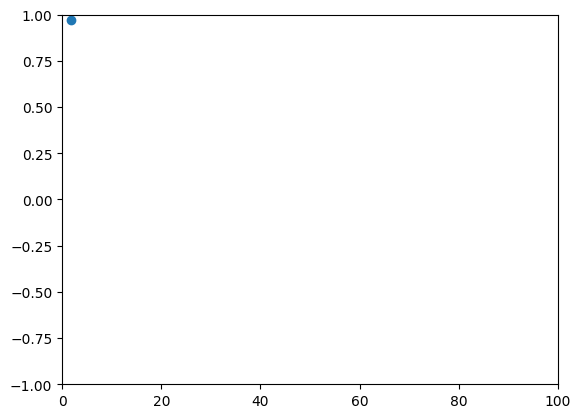

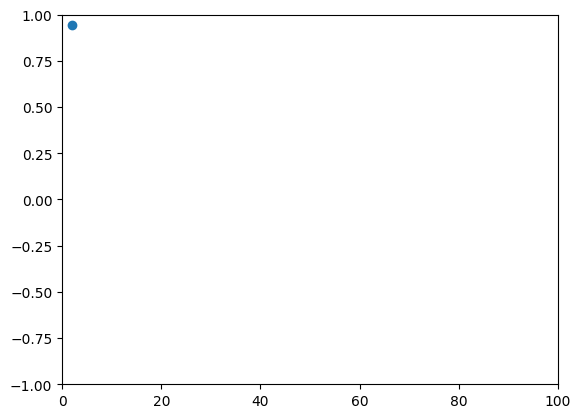

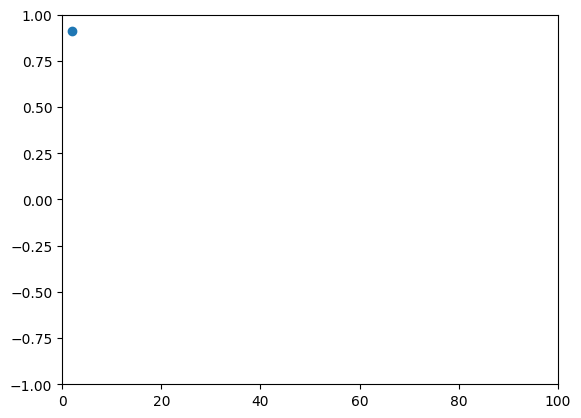

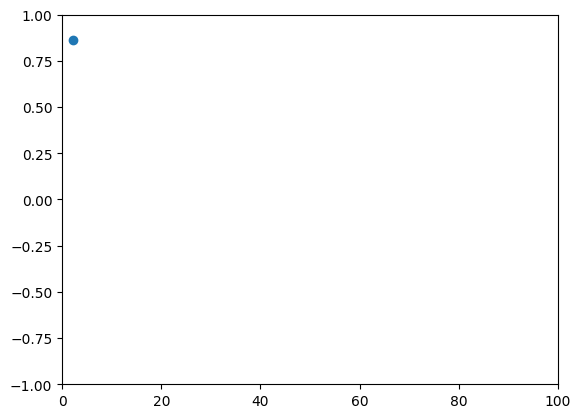

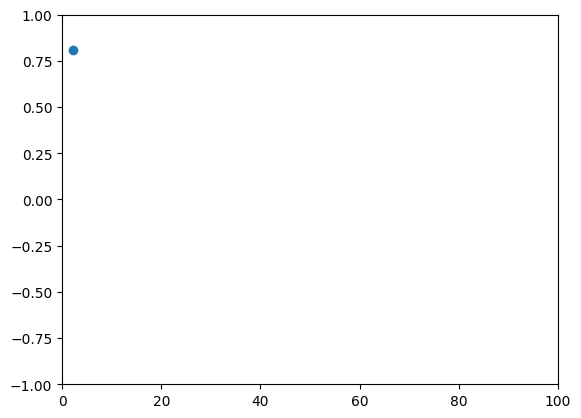

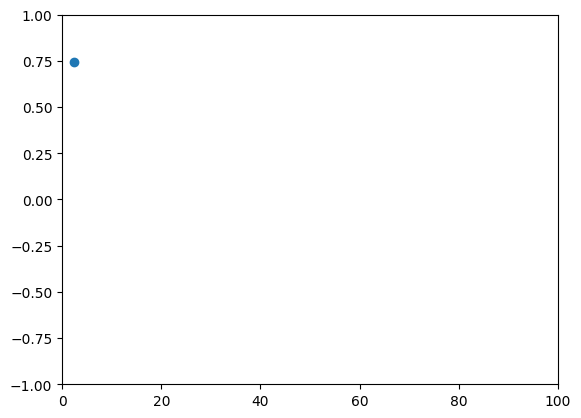

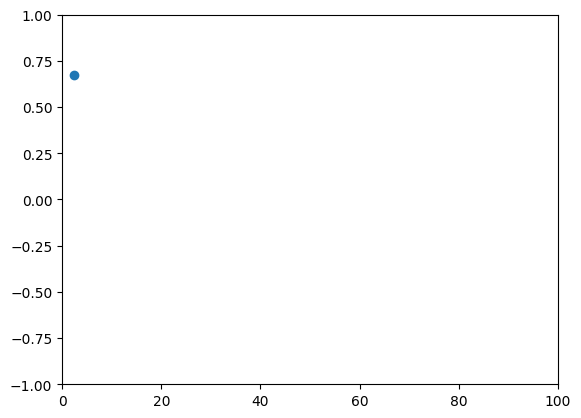

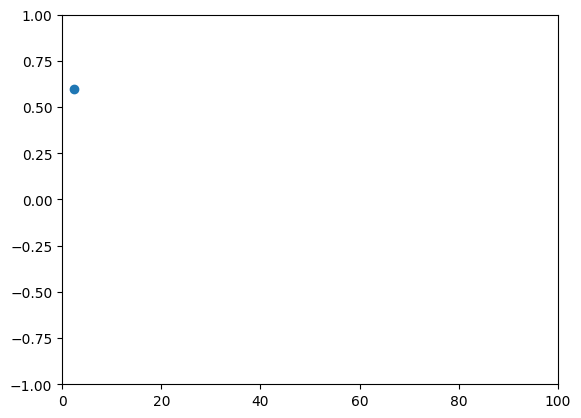

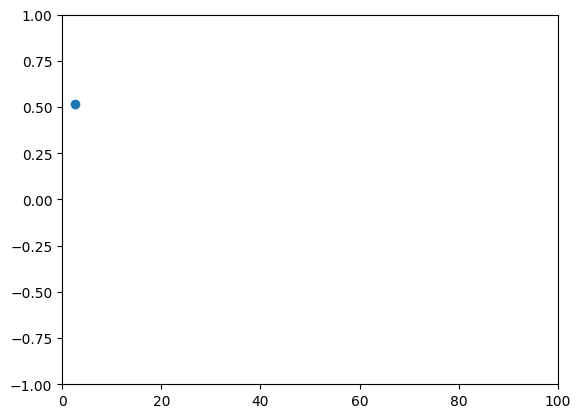

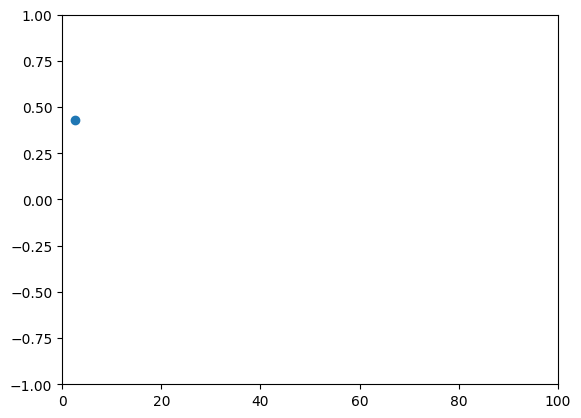

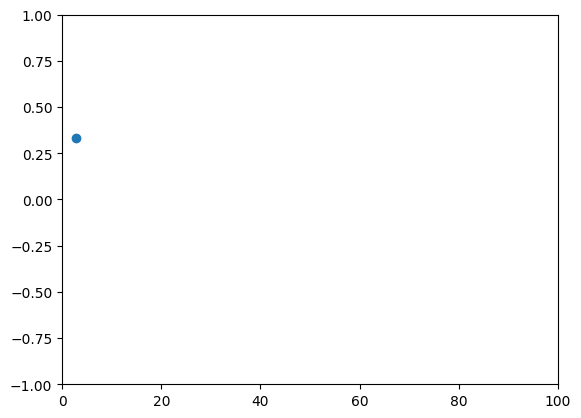

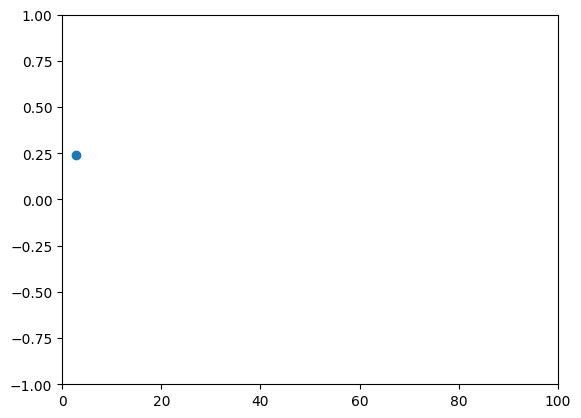

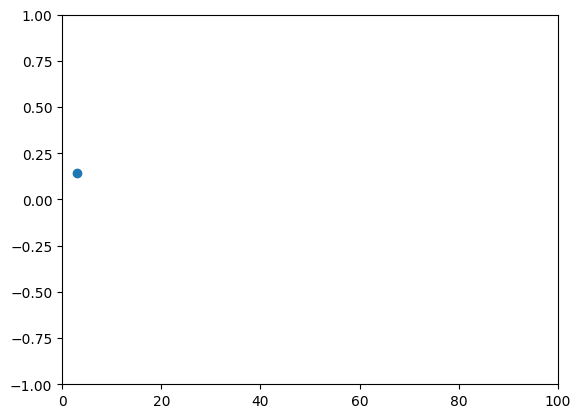

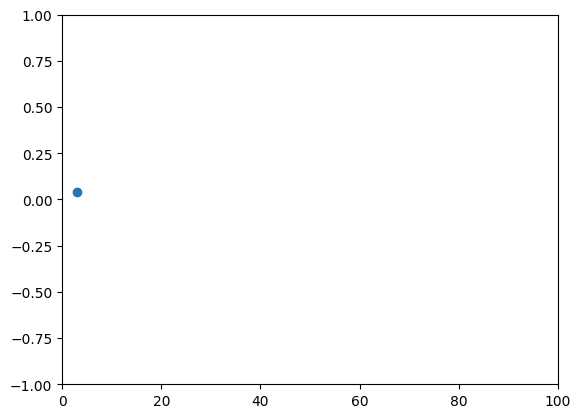

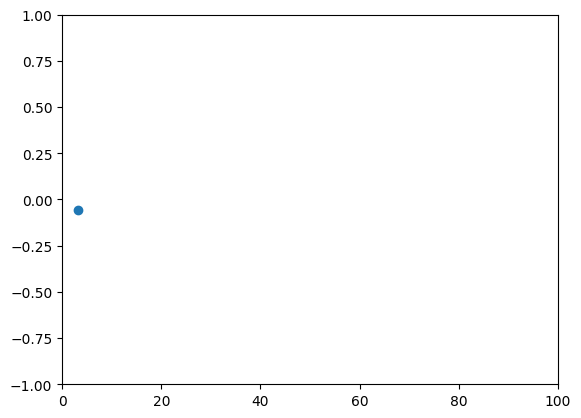

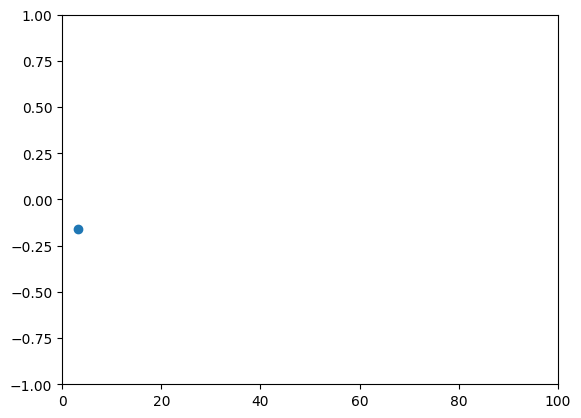

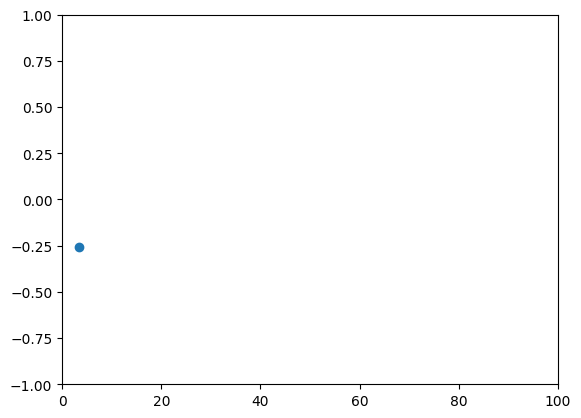

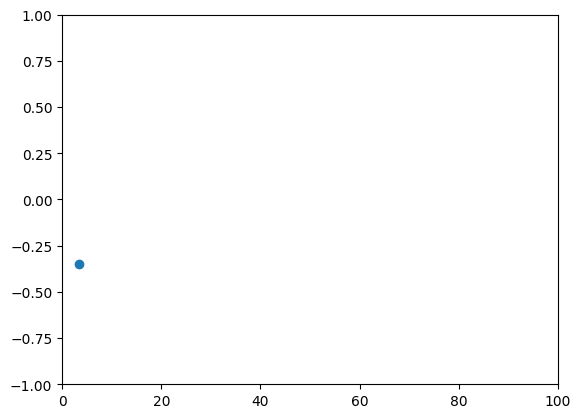

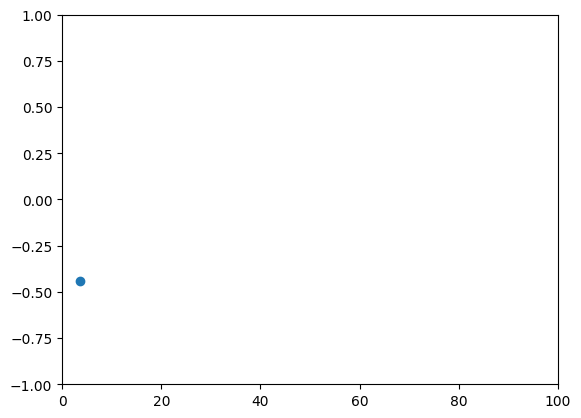

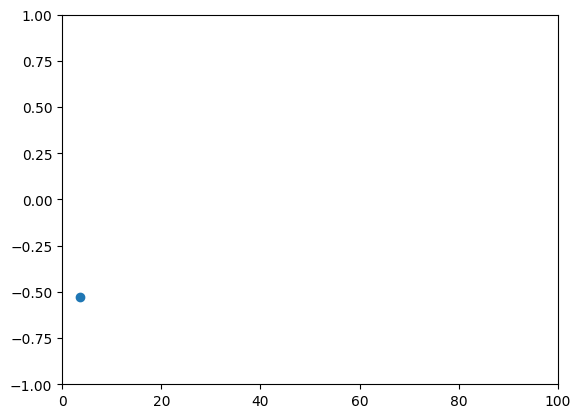

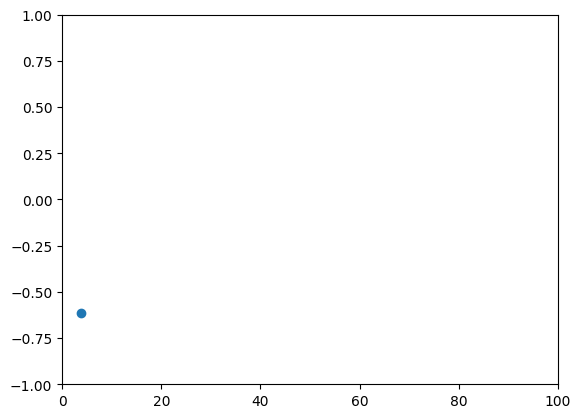

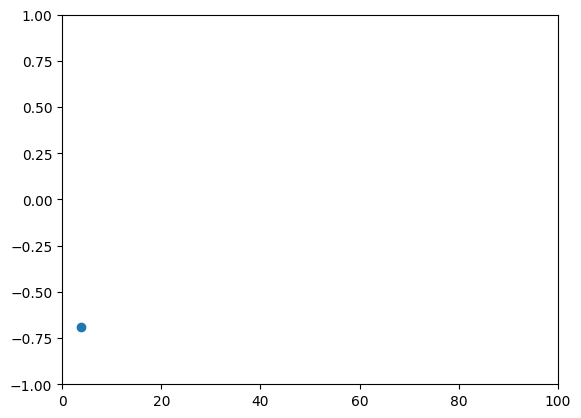

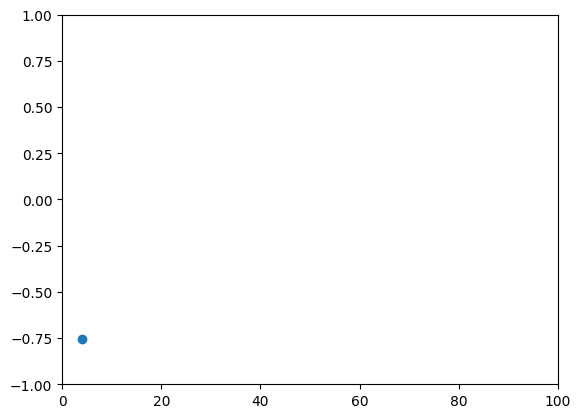

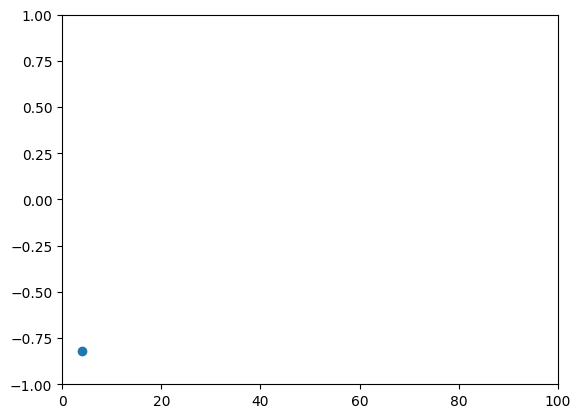

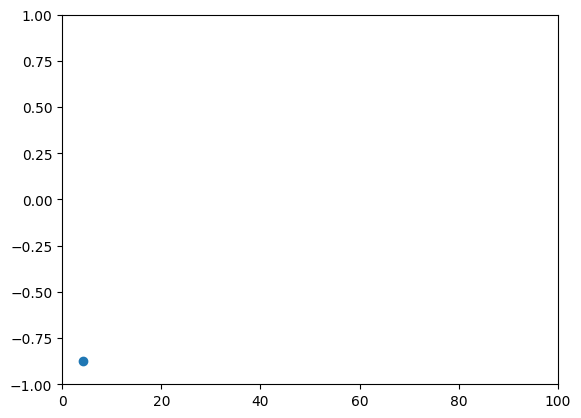

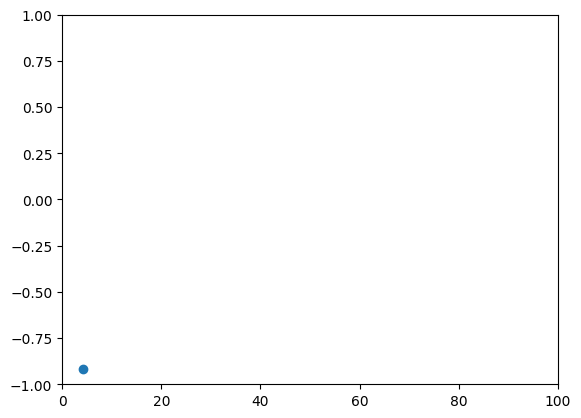

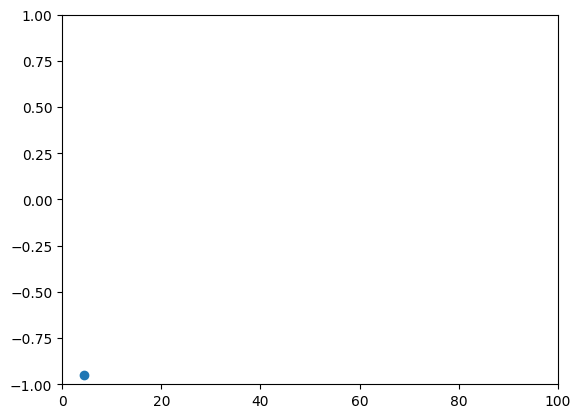

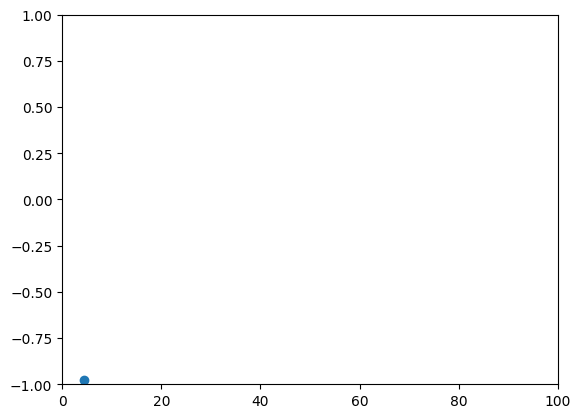

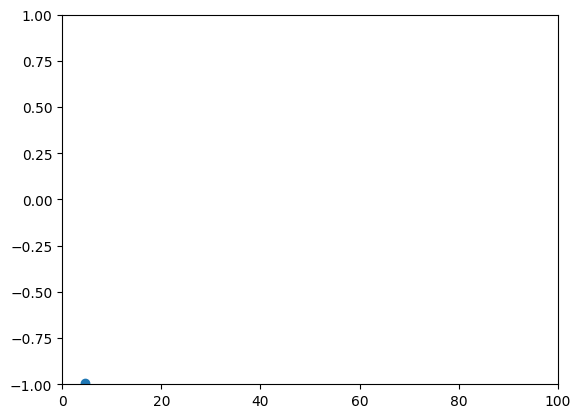

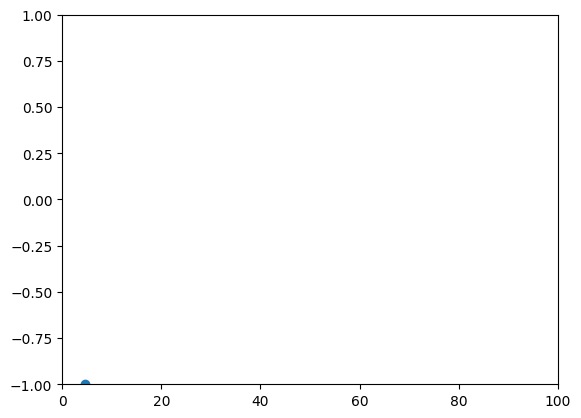

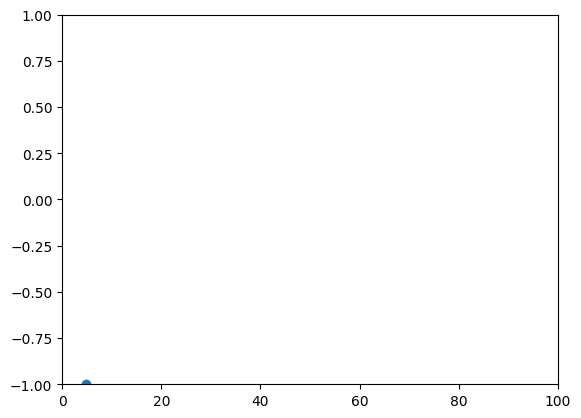

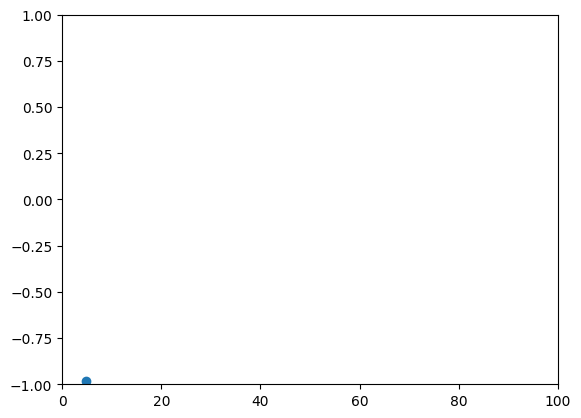

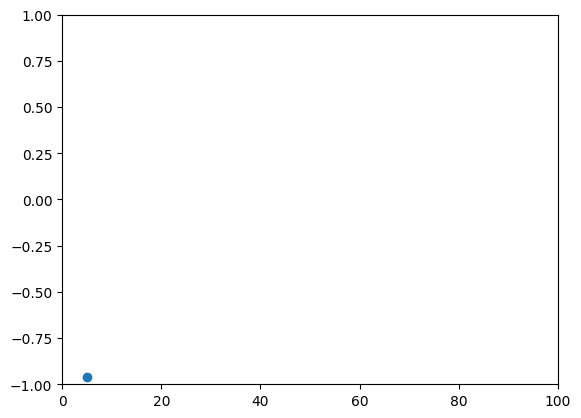

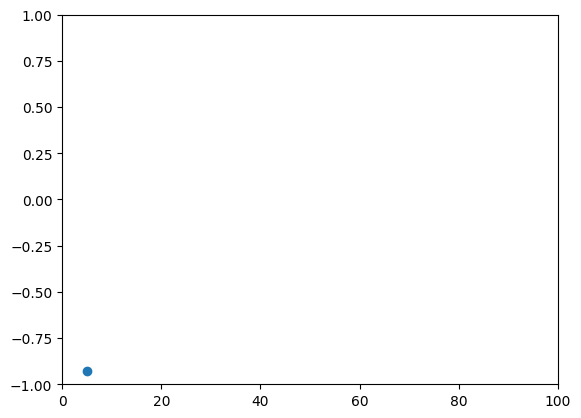

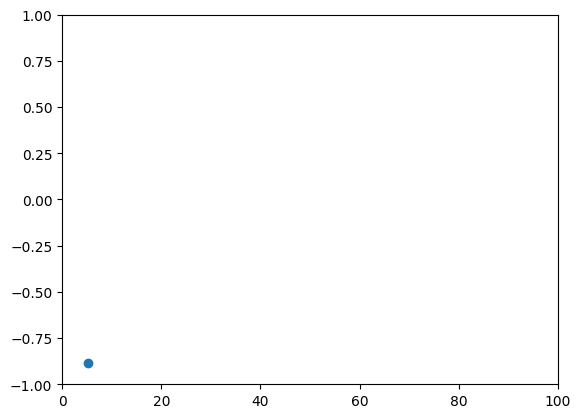

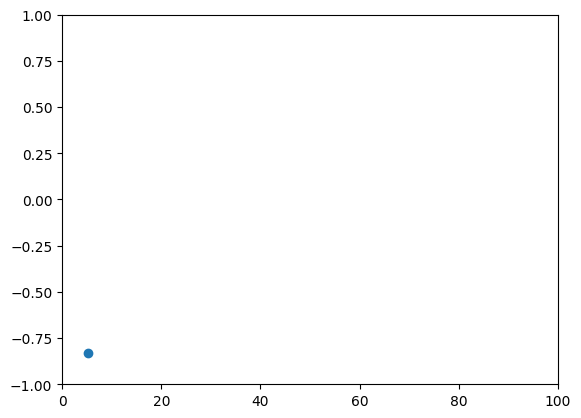

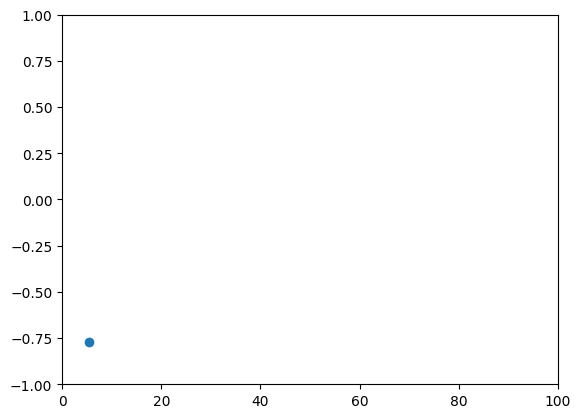

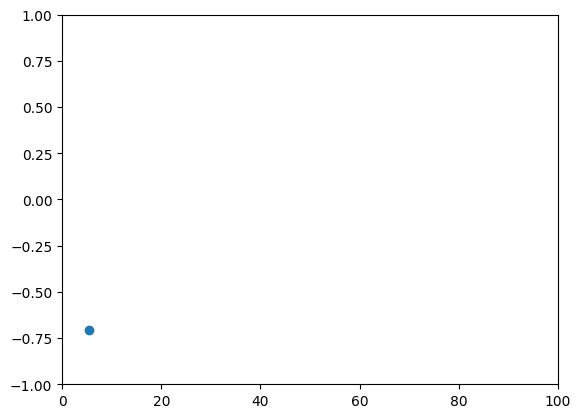

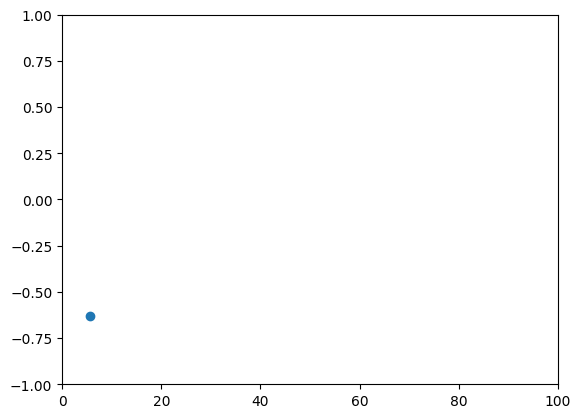

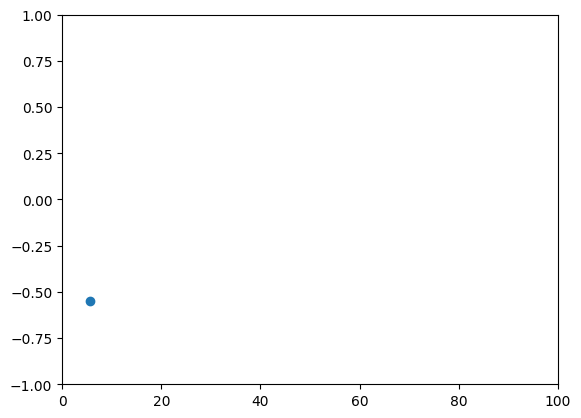

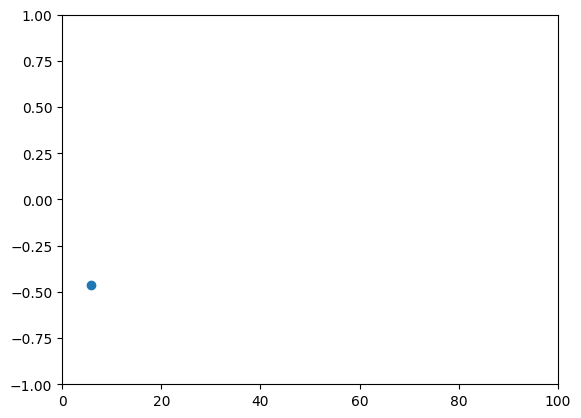

KeyboardInterrupt: 

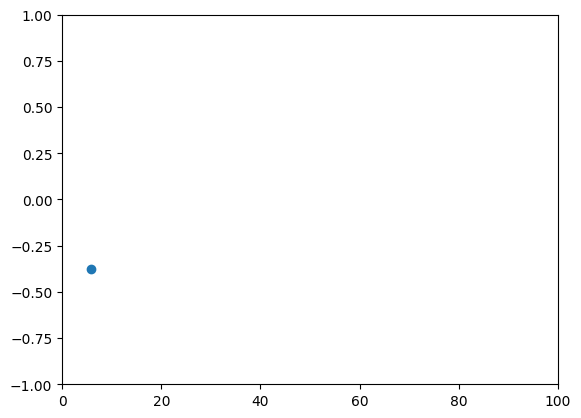

In [15]:
x = 0
for _ in range(1000):
    plt.cla()
    x += 0.1
    y = np.sin(x)
    plt.scatter(x, y)
    plt.xlim([0, 100])
    plt.ylim([-1, 1])
    plt.pause(0.001)
    
plt.show()

## 그래프 그리기

/var/folders/gt/wdmlmv_d6jl1q6cvjxq5n_w00000gn/T/ipykernel_94968/712137643.py:44: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, frame_count)


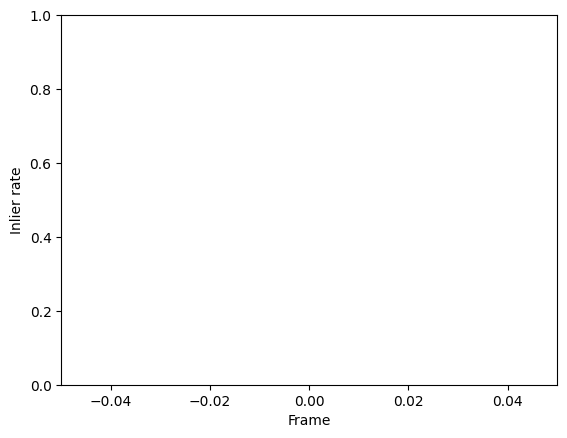

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

In [32]:
import matplotlib.pyplot as plt
import cv2

plt.ion()  # 인터랙티브 모드 활성화

cap = cv2.VideoCapture('demo_video_resized.mp4')
inlier_rates_y = []

fig, ax = plt.subplots()
ax.set_xlabel('Frame')
ax.set_ylabel('Inlier rate')
ax.set_xlim(0, None)
ax.set_ylim(0, 1.0)

frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    feats0 = extractor.extract(image0.to(device))
    image1 = stabilizer.stabilize_frame(input_frame = frame)
    image1 = load_image(frame, grayscale=True)
    feats1 = extractor.extract(image1.to(device))
    
    matches01 = matcher({"image0": feats0, "image1": feats1})
    
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension
    
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    
    homography, inlier_rate = CSRansac.csransac(m_kpts0.cpu().numpy(), m_kpts1.cpu().numpy())
    
    inlier_rates_y.append(inlier_rate)
    
    ax.clear()
    ax.plot(frame_count, inlier_rates_y)
    ax.set_xlabel('Frame')
    ax.set_ylabel('Inlier rate')
    ax.set_xlim(0, frame_count)
    ax.set_ylim(0, 1.0)
    plt.pause(0.01)
    
    frame_count += 1

plt.ioff()  # 인터랙티브 모드 비활성화
plt.show()


## check speed

In [ ]:
# 테스트용

# video_frames 폴더에서 프레임 파일 리스트 가져오기
video_frames = os.listdir('video')

# 프레임 수 초기화
frame_count = 0

# 프레임 별 처리 시간 리스트 초기화
frame_processing_times = []

x = 637 // 2
y = 367 // 2
image0 = load_image("img1.png", grayscale=True)

# 각 프레임 처리
for frame in video_frames:
    start_time = time.time()
    
    #image0 = load_image("img1.png", grayscale=True)
    feats0 = extractor.extract(image0.to(device))
    image1 = load_image_from_path(os.path.join('video', frame), grayscale=True)
    feats1 = extractor.extract(image1.to(device))

    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    homography, _ = CSRansac.csransac(m_kpts0.cpu().numpy(), m_kpts1.cpu().numpy())
    projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)

    # 현재 시간 측정
    current_time = time.time()

    # 프레임 처리 시간 계산
    frame_processing_time = current_time - start_time
    frame_processing_times.append(frame_processing_time)

    # 이전 프레임 처리 시간 업데이트
    prev_frame_time = current_time

    # FPS 계산
    fps = 1.0 / frame_processing_time

    # 프레임 수 증가
    frame_count += 1

    # 이미지 및 매칭 시각화 코드 (생략)

# 전체 처리 시간 계산
total_processing_time = sum(frame_processing_times)

# 전체 프레임 수와 전체 처리 시간을 사용하여 평균 FPS 계산
average_fps = frame_count / total_processing_time

print(f"Total Frames Processed: {frame_count}")
print(f"Average FPS: {average_fps:.2f}")

## 실험 데이터셋 재생 코드

In [ ]:
failed_inliers = 0
    
# 좌표의 개수(동영상의 개수)만큼 반복
for i in range(1):
    _images = images[0]
    _len_images = len(_images)
    x = origin_coordinate[0][0]
    y = origin_coordinate[0][1]

    img0 = _images[0] # 첫 번째 이미지를 target 이미지로 설정
    for j in range(_len_images):
        if j == 0:
            continue
        
        img1 = _images[j]
        _img1 = cv2.imread(img1)

        # LightGlue
        results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
        target_keypoint = results_lightglue["points0"].cpu().numpy()
        frame_keypoint = results_lightglue["points1"].cpu().numpy()

        homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
        print(mask)
        if mask < 0.3:
            failed_inliers += 1
            cv2.imshow('frame', _img1)
            img0 = img1
            continue
        projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)
        
        img0 = img1
        
        cv2.circle(_img1, (int(projected_pts[0]), int(projected_pts[1])), 15, (0, 0, 255), -1)
        cv2.circle(_img1, (int(projected_pts[0]), int(projected_pts[1])), 3, (0, 0, 0), -1)
        cv2.imshow('frame', _img1)
        
        key = cv2.waitKey(5)
        if key == 27:
            break
            
cv2.destroyAllWindows()
print("failed_inliers:", failed_inliers)
            

0.9755434782608695
0.6622983870967742
0.8769551616266945
-1
0.9988439306358381
-1
0.8955223880597015
-1
0.9721485411140584
0.9660056657223796
0.9686162624821684
0.3789173789173789
0.8782234957020058
0.9985250737463127
0.7752293577981652
0.9968992248062015
0.9968553459119497
0.9542682926829268
-1
0.37285491419656785
0.8927444794952681
0.913961038961039
0.9984202211690363
0.9984615384615385
-1
0.9984177215189873
0.9403225806451613
0.9268680445151033
0.9616564417177914
0.9667721518987342
0.8056338028169014
0.8379160636758322
0.5329428989751098
0.9357664233576642
0.9954476479514416
0.9204892966360856
0.5672782874617737
0.9405646359583952
0.2556732223903177
0.974124809741248
0.9969135802469136
0.9827856025039123
0.9953846153846154
0.9426356589147287
-1
-1
-1
0.9984375
0.9301948051948052
-1
0.9984472049689441
0.998468606431853
0.8180404354587869
-1
0.9165378670788253
-1
0.9877862595419847
0.9909502262443439
0.4391371340523883
0.9983766233766234
0.9986225895316805
0.992867332382311
0.99146514

In [47]:
# 광학 추적 방식 + 칼만 필터
import cv2
import time
import CSRansac
import numpy as np

# 칼만 필터 초기화
kalman = cv2.KalmanFilter(8, 4)
kalman.measurementMatrix = np.eye(4, 8, dtype=np.float32)
kalman.transitionMatrix = np.eye(8, dtype=np.float32)
kalman.processNoiseCov = np.eye(8, dtype=np.float32) * 0.01
kalman.measurementNoiseCov = np.eye(4, dtype=np.float32) * 0.1
kalman.errorCovPost = np.eye(8, dtype=np.float32)

# 비디오 캡처 객체 초기화
cap = cv2.VideoCapture('demo_video_resized.mp4')

# 예시 좌표
x, y = 637 / 2, 367 / 2  
points = np.array([[x, y]], dtype='float32')

# 원본 이미지와 투영할 좌표
origin_image = cv2.imread('img0.png')
prev_gray = cv2.cvtColor(origin_image, cv2.COLOR_BGR2GRAY)

# Lucas-Kanade optical flow 파라미터
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# 좋은 특징점 찾기 파라미터
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# 첫 프레임에서 특징점 찾기
# prev_points = (cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params))
img0 = load_image("img0.png", grayscale=True)
prev_points = extractor.extract(img0.to(device))
prev_points = prev_points["keypoints"]
prev_points = prev_points.cpu().numpy()
prev_points = prev_points.reshape(-1, 1, 2)

# 프레임 수 초기화
frame_count = 0

failed_inliers_count = 0
inlier_rates=0
# 프레임 별 처리 시간 리스트 초기화
total_processing_time = 0

first = 0

start_time = time.time()
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    if first == 0:
        first = 1
        continue
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    next_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None, **lk_params)
    good_old = prev_points[status == 1]
    good_new = next_points[status == 1]
    
    if len(good_new) >= 4:
        H, mask = cv2.findHomography(good_old, good_new, cv2.RANSAC, 5.0)
        if H is not None:
            inliers = CSRansac.calculate_inliers(H, good_old, good_new, 5)
            inlier_rate = inliers / len(good_old)
            # print(float(inlier_rate))
            if inlier_rate <= 0.3:
                failed_inliers += 1
            inlier_rates += inlier_rate
            
            # 원본 이미지의 좌표를 변환
            projected_points = cv2.perspectiveTransform(np.array([points]), H)
            # 칼만 필터 업데이트
            measured = np.array([[projected_points[0][0][0], projected_points[0][0][1], 0, 0]], dtype=np.float32).T
            kalman.correct(measured)
            prediction = kalman.predict()
            predicted_points = (prediction[0][0], prediction[1][0])
            # 결과 표시
            cv2.circle(frame, (int(predicted_points[0]), int(predicted_points[1])), 5, (0, 0, 255), -1)
            print(predicted_points)
    
    prev_gray = gray
    prev_points = good_new.reshape(-1, 1, 2)
    
    # 프레임 수 증가
    frame_count += 1
    
    cv2.imshow('frame', frame)
    if cv2.waitKey(30) & 0xFF == 27:
        break


# 현재 프레임 처리 시간 측정
end_time = time.time()
frame_processing_time = end_time - start_time
total_processing_time += frame_processing_time

cap.release()
cv2.destroyAllWindows()

# 전체 프레임 수와 전체 처리 시간을 사용하여 평균 FPS 계산
average_fps = frame_count / total_processing_time

print(f"Total Frames Processed: {frame_count}")
print(f"Average FPS: {average_fps:.2f}")
print(f"Failed Inliers: {failed_inliers_count}")
print(f"Inlier Rate: {inlier_rates / frame_count}")

(0.0, 0.0)
(28.90707, 16.67526)
(75.24615, 43.40535)
(125.37751, 72.33176)
(170.59055, 98.39343)
(207.52646, 119.72684)
(236.21468, 136.27046)
(257.84634, 148.74069)
(273.9246, 158.01726)
(285.75305, 164.84534)
(294.44293, 169.85716)
(300.80267, 173.51752)
(305.4455, 176.19681)
(308.84888, 178.15263)
(311.3225, 179.5756)
(313.12332, 180.62128)
(314.4589, 181.37888)
(315.4195, 181.9369)
(316.1161, 182.34424)
(316.63666, 182.63983)
(317.0161, 182.85571)
(317.2871, 183.0094)
(317.4914, 183.12755)
(317.64444, 183.21645)
(317.75375, 183.2782)
(317.8369, 183.31633)
(317.90112, 183.34714)
(317.94138, 183.37773)
(317.97968, 183.39844)
(317.98853, 183.42204)
(318.00827, 183.43542)
(318.0178, 183.44304)
(318.03452, 183.44905)
(318.03555, 183.45512)
(318.04633, 183.45457)
(318.05582, 183.4597)
(318.06702, 183.45938)
(318.06857, 183.45871)
(318.07486, 183.46211)
(318.07895, 183.46117)
(318.0901, 183.4664)
(318.08847, 183.46613)
(318.08255, 183.47145)
(318.09482, 183.4727)
(318.0987, 183.47702)
(31

In [ ]:
# 기존 추출 알고리즘 + 칼만 필터
import cv2
import time
import CSRansac
import numpy as np

# 칼만 필터 초기화
kalman = cv2.KalmanFilter(8, 4)
kalman.measurementMatrix = np.eye(4, 8, dtype=np.float32)
kalman.transitionMatrix = np.eye(8, dtype=np.float32)
kalman.processNoiseCov = np.eye(8, dtype=np.float32) * 0.01
kalman.measurementNoiseCov = np.eye(4, dtype=np.float32) * 0.1
kalman.errorCovPost = np.eye(8, dtype=np.float32)

failed_inliers = 0
    
# 좌표의 개수(동영상의 개수)만큼 반복
for i in range(1):
    _images = images[0]
    _len_images = len(_images)
    x = origin_coordinate[0][0]
    y = origin_coordinate[0][1]

    img0 = _images[0] # 첫 번째 이미지를 target 이미지로 설정
    for j in range(_len_images):
        if j == 0:
            continue
        
        img1 = _images[j]
        _img1 = cv2.imread(img1)

        # LightGlue
        results_lightglue = matching_keypoints(img0, img1, stabilizing=False)
        target_keypoint = results_lightglue["points0"].cpu().numpy()
        frame_keypoint = results_lightglue["points1"].cpu().numpy()

        homography, mask = CSRansac.csransac(target_keypoint, frame_keypoint)
        if mask < 0.3:
            failed_inliers += 1
            cv2.imshow('frame', _img1)
            img0 = img1
            continue
        
        projected_pts = CSRansac.perspective_transform(np.array([x, y]), homography)
        measured = np.array([[projected_pts[0][0][0], projected_pts[0][0][1], 0, 0]], dtype=np.float32).T
        kalman.correct(measured)
        prediction = kalman.predict()
        predicted_points = (prediction[0][0], prediction[1][0])
        
        img0 = img1
        
        cv2.circle(_img1, (int(predicted_points[0]), int(predicted_points[1])), 15, (0, 0, 255), -1)
        cv2.circle(_img1, (int(predicted_points[0]), int(predicted_points[1])), 3, (0, 0, 0), -1)
        cv2.imshow('frame', _img1)
        
        key = cv2.waitKey(5)
        if key == 27:
            break
    break
            
cv2.destroyAllWindows()
print("failed_inliers:", failed_inliers)
            